<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/3_realtime_ser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition (Classification) in real-time using Deep LSTM layers**
### ***Real-time implementaion of the SER model***
---




# **ABSTRACT**
This implementation of a pre-trained Speech Emotion Recognition (SER) model is designed to perform real-time analysis of vocal input, enabling the identification and visualization of the emotional states expressed in speech.

Emotion recognition from speech is inherently a temporal task rather than an instantaneous one. From a linguistic perspective, identical phrases can convey vastly different emotions depending on prosodic variations such as intonation, stress, or even the emphasis on a single syllable.

The model employed in this system is a Long Short-Term Memory (LSTM) based deep learning network, which achieves a classification accuracy of 87.23%. It has been trained to capture and interpret long-term dependencies in speech by learning patterns within sequences of audio-derived features, such as Mel-Frequency Cepstral Coefficients (MFCCs), Zero-Crossing Rate (ZCR), and Root Mean Square (RMS) energy.

The system captures audio input via the platform's microphone, stores it temporarily in a .wav file, preprocesses the signal to extract relevant features, and then generates a probabilistic distribution over a predefined set of emotion categories. Each processing cycle analyzes a 7.1-second segment of speech.

The recognition loop continues iteratively as long as continuous speech is detected. Upon detecting a silence of two seconds or more, the system terminates the session. At the conclusion of each session, it presents a summary visualization based on the mean emotion probabilities computed across all recorded segments.



# **LIBRARIES & GOOGLE AUTH**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [3]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

# **LOAD MODEL**
Loading the speech emotion recognition LSTM model and weights.

In [5]:
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/model.weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 400, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None


# **DATA PREPROCESSING**

#Audio Preprocessing Pipeline for Speech Emotion Recognition (SER)
The input .wav audio signal undergoes a structured preprocessing routine aligned with the model's training configuration:

* Sampling Rate Acquisition is performed via librosa to ensure temporal fidelity of the signal.
* Signal Loading and Amplitude Normalization are executed using pydub, adjusting the dynamic range to `+5.0 dBFS` for consistent loudness levels.

* Waveform Vectorization converts the normalized audio to a numerical array using numpy.

* Denoising is applied using the noisereduce library to enhance the signal-to-noise ratio.

Subsequently, the following low-level acoustic descriptors are extracted:

1. Root Mean Square Energy (RMS) – quantifies the signal’s power envelope.

2. Zero-Crossing Rate (ZCR) – captures frequency transitions and signal noisiness.

3. Mel-Frequency Cepstral Coefficients (MFCCs) – represent the timbral and spectral properties of speech.

Feature extraction is parameterized with frame_length = 2048 and hop_length = 512, ensuring uniform temporal resolution. The resulting feature matrix is concatenated and reshaped to a 3D tensor X_3D ∈ ℝ(1 × T × F) — where T is the number of time steps and F the feature dimensionality — for direct compatibility with the LSTM-based SER architecture

In [12]:
def preprocess(file_path, frame_length=2048, hop_length=512):
    '''
    Preprocesses an audio .wav file before executing a prediction.

    Arguments:
      - file_path: The full path to the audio file.
      - frame_length: Frame size for feature extraction. Default is 2048.
      - hop_length: Hop size between frames. Default is 512.

    Returns:
      - X_3D: A 3D array (batch, timesteps, features) suitable for model input.
    '''

    # Fetch sample rate
    _, sr = librosa.load(path=file_path, sr=None)

    # Load audio file
    rawsound = AudioSegment.from_file(file_path)

    # Normalize volume
    normalizedsound = effects.normalize(rawsound, headroom=5.0)

    # Convert audio to numpy array
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

    # Noise reduction
    final_x = nr.reduce_noise(y=normal_x, sr=sr)
    # Feature extraction
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T
    f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True).T
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length).T

    # Combine features
    X = np.concatenate((f1, f2, f3), axis=1)

    # Add batch dimension
    X_3D = np.expand_dims(X, axis=0)

    return X_3D


# **Additional System Configuration**
- An **emotion label mapping list** is initialized to interpret the model’s numerical output into human-readable categorical emotions.

- The `is_silent()` utility function serves as a binary audio activity detector, returning True when the peak amplitude of the input signal falls below a predefined threshold—indicative of a silent or non-speech segment. This facilitates dynamic session control by terminating the emotion recognition process upon prolonged silence.


In [13]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


# **REAL-TIME IMPLEMENTATION**

- This implementation operationalizes a pre-trained LSTM-based Speech Emotion Recognition (SER) model
- for real-time inference on live audio input captured via the system's soundcard.
- The execution pipeline comprises the following sequential stages:

1.   Session initialization, establishing an input audio stream using `pyaudio`.

2.   If **non-silent** input is detected, the incoming audio frames are buffered and stored
     in a temporary `.wav` file using `pyaudio` and `wave` libraries.

    2.1  After a 7.1-second audio window, recording pauses momentarily to allow preprocessing and prediction on the accumulated waveform before resuming.

    2.2  The temporary `.wav` file undergoes signal conditioning and feature extraction via the `preprocess` function.

    2.3  The preprocessed audio tensor is passed to `model.predict()`, which returns an 8-dimensional probability vector representing the likelihood of each emotion class: `predictions = [array([p_neutral, p_calm, p_happy, p_sad, p_angry, p_fearful, p_disgust, p_surprised], dtype=float32)]`

    2.4  The predictions are vectorized and stripped of metadata (e.g., dtype annotations) for interpretability and stored for aggregation.

    2.5  Emotion probability distributions for each recording window are visualized dynamically using `matplotlib`.

3.   If silence is detected in the final 2-second window of audio (below a predefined threshold):

    3.1  The loop is terminated, session ends, and audio streams are closed to release system resources.

    3.2  A session-level summary is rendered, showing the mean probabilities across all emotion categories.

    3.3  The cumulative session duration is printed.

## **VARIABLES EXPLAINED**
RATE = Sampling rate (24414 Hz), aligned with the training configuration of the LSTM model.

CHUNK = Frame buffer size for streaming (512 samples), analogous to `hop_length` in `librosa`.

FORMAT = Audio bit depth, set to 32-bit integers (`paInt32`) for compatibility with the model's input profile.

CHANNELS = Mono audio configuration (single channel), typical for microphone input in consumer devices.


<ipython-input-12-d370a7141667>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  _, sr = librosa.load(path=file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


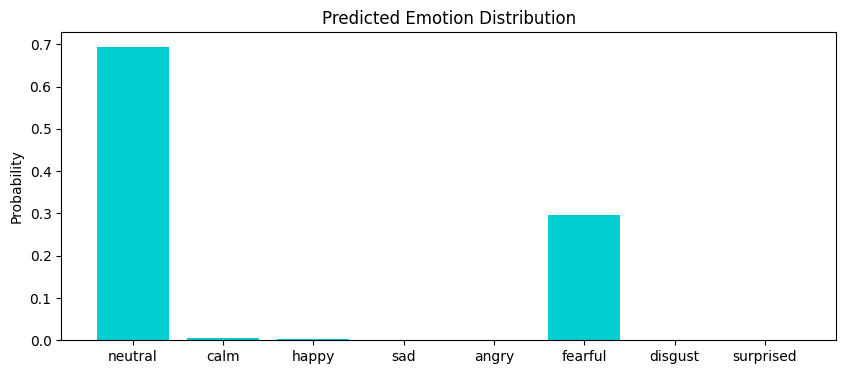

 Predicted Emotion: neutral


In [36]:
emo_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotions = {i: emo for i, emo in enumerate(emo_list)}

# Use the uploaded audio file
file_path = "/content/drive/My Drive/Colab Notebooks/nominew.wav"

# Preprocess and predict
x = preprocess(file_path)
predictions = model.predict(x)
pred_np = predictions[0]

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(emo_list, pred_np, color='darkturquoise')
plt.ylabel("Probability")
plt.title("Predicted Emotion Distribution")
plt.show()

# Print most likely emotion
print(" Predicted Emotion:", emotions[np.argmax(pred_np)])